In [ ]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow h5py

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


## Read Data

In [3]:
featFileName = "./Data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)

In [4]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']
bat_info

,policy,barcode,cycle_life
0,3_6C-80PER_3_6C,???,1189
1,3_6C-80PER_3_6C,???,1178
2,3_6C-80PER_3_6C,???,1176
3,4C-80PER_4C,???,1225
4,4C-80PER_4C,???,1226
...,...,...,...
75,6C_31PER_4_25C,???,462
76,6C_40PER_4C,???,457
77,6C_4PER_4_75C,???,487
78,6C_52PER_3_5C,???,429


In [5]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.071,  0.468,  1.076, ...,  1.091,  0.   ,  1.072],
       [ 1.075,  0.009,  1.081, ...,  1.081, -0.   ,  1.085],
       [ 1.08 ,  0.008,  1.085, ...,  1.085, -0.   ,  1.089],
       ...,
       [ 1.07 ,  0.005,  1.073, ...,  1.075, -0.   ,  1.081],
       [ 1.073,  0.007,  1.08 , ...,  1.078, -0.   ,  1.081],
       [ 1.042,  0.008,  1.047, ...,  1.049, -0.   ,  1.055]])

## Clean the Data

In [6]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

## Train-Test split

In [7]:
feat_train = feat[0::2]
feat_test = feat[1::2]
label_train = bat_info["cycle_life"][0::2]
label_test = bat_info["cycle_life"][1::2]

## Normalization

In [8]:
batch_pd.drop(['policy','barcode','QDiffLinVar'], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle_life,80.0,658.425000,237.515344,148.000000,480.750000,578.000000,844.000000,1226.000000
QD2,80.0,1.074407,0.008425,1.042137,1.070368,1.074676,1.079112,1.094639
QD(Max-2),80.0,0.033860,0.208521,0.001546,0.004169,0.005161,0.006591,1.817914
QD100,80.0,1.074702,0.016475,0.968339,1.071743,1.078276,1.082280,1.095762
QDiffMin,80.0,-1.366400,0.193884,-2.072648,-1.430311,-1.345441,-1.248456,-0.860038
QDiffMean,80.0,-1.712803,0.232730,-2.541602,-1.794486,-1.681735,-1.586377,-1.109668
QDiffVar,80.0,-3.700346,0.394717,-5.014861,-3.845688,-3.648272,-3.487896,-2.726901
QDiffSkew,80.0,-0.835239,0.418983,-2.337813,-1.047574,-0.834964,-0.544644,0.033502
QDiffKurtosis,80.0,0.083591,0.083133,-0.457627,0.082972,0.103917,0.117703,0.142137
QDiffStart,80.0,-4.227185,0.525039,-5.820917,-4.540804,-4.149654,-3.793068,-3.399592


In [9]:
# label_train = np.log10(label_train)
# label_test = np.log10(label_test)

In [9]:
# equivalent to step "scale data" in original version
normalizer = layers.Normalization(input_shape=[13, ], axis=None)
normalizer.adapt(feat_train)

In [10]:
print(normalizer.mean.numpy())

[[-0.571]]


## Linear regression

In [11]:
# simulate training the model against log10(cycle_life)
power10 = layers.Lambda(lambda x: tf.constant(10.0)**x)

In [12]:
discharge_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1),
    power10
])

discharge_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 14        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 17
Trainable params: 14
Non-trainable params: 3
_________________________________________________________________


Run the untrained model on the first 10 batteries' features. The output won't be good, but notice that it has the expected shape of `(10, 13)`:

In [13]:
discharge_model.predict(feat_train[:10])

1/1 [==============================] - 0s 79ms/step


array([[17.176],
       [10.804],
       [11.005],
       [ 4.566],
       [ 6.337],
       [ 7.422],
       [ 5.685],
       [ 6.004],
       [ 5.889],
       [ 5.459]], dtype=float32)

In [14]:
discharge_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

In [15]:
%%time
history = discharge_model.fit(
    feat_train,
    label_train,
    epochs=5000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 1min 54s
Wall time: 1min 38s


## Evaluation
Note: since model has been configured to use Mean Squared Error to evaluate loss/cost, will need to square root the loss statistic to get **Root** Mean Squared Error as measured by authors.

In [23]:
def plot_loss(history):
  plt.plot(np.sqrt(history.history['loss']), label='loss')
  plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
  # plt.ylim([200, 130])
  plt.ylim([50, 300])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)

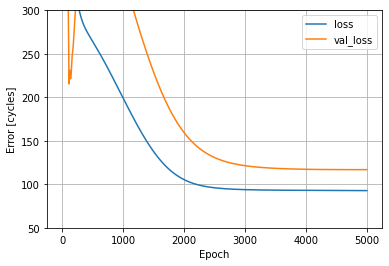

In [24]:
plot_loss(history)

In [20]:
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
4995,92.764613,116.880865,4995
4996,92.764229,116.880590,4996
4997,92.763945,116.880953,4997
4998,92.763497,116.880916,4998
4999,92.763229,116.881617,4999


In [27]:
# Power 1/2 is the same as square root
discharge_model.evaluate(
    feat_test,
    label_test, verbose=0) ** 0.5

149.03570251788662

In [21]:
def plot_accuracy(y_train, y_test):
  plt.scatter(y_train, label_train, label='Predictions (train)')
  plt.scatter(y_test, label_test, label='Predictions (test)')
  plt.plot([0, 2000], [0, 2000], color='k', label='Perfection')
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

2/2 [==============================] - 0s 2ms/step


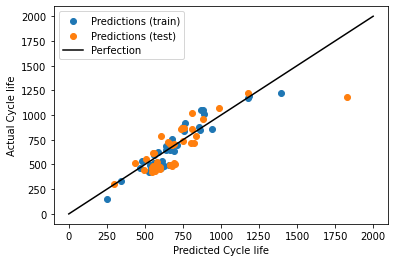

In [22]:
plot_accuracy(discharge_model.predict(feat_train), discharge_model.predict(feat_test))